In [1]:
%config Completer.use_jedi = False

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import warnings
import preprocess
import fasttext.util
import spacy_stanza
from spacytextblob.spacytextblob import SpacyTextBlob
import re
from nltk.corpus import stopwords 
import swifter

nlp = spacy_stanza.load_pipeline("en", use_gpu=False)
fasttext.util.download_model('en', if_exists='ignore')
warnings.filterwarnings("ignore")
stop_words = stopwords.words('english')

from fastai.text import *
from fastai.text.all import *

2022-03-09 19:22:41 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| depparse     | combined  |
| sentiment    | sstplus   |
| constituency | wsj       |
| ner          | ontonotes |

2022-03-09 19:22:41 INFO: Use device: cpu
2022-03-09 19:22:41 INFO: Loading: tokenize
2022-03-09 19:22:41 INFO: Loading: pos
2022-03-09 19:22:41 INFO: Loading: lemma
2022-03-09 19:22:41 INFO: Loading: depparse
2022-03-09 19:22:42 INFO: Loading: sentiment
2022-03-09 19:22:43 INFO: Loading: constituency
2022-03-09 19:22:43 INFO: Loading: ner
2022-03-09 19:22:44 INFO: Done loading processors!


In [2]:
train_df = pd.read_excel('yulu_analysis_selected.xlsx').fillna('').drop(['Unnamed: 0'], axis = 1)
test_df = pd.read_excel('Yulu_dataanalysis.xlsx').rename(columns = {'Unnamed: 0': 'index'}).fillna('')

tqdm.pandas()

class_list = list(train_df.columns)[2:]
#class_list.pop(0)
#class_list.pop(0)
df_orig = test_df.copy()

In [3]:
def column_regularize(df):
    for col in df.columns:
        df.rename(columns = {col:''.join(col.strip().lower().split(' '))}, inplace = True)
        df.rename(columns = {col:''.join(col.strip().lower().split('_'))}, inplace = True)
    return df

def phraser(x):
    phrase_list = preprocess.preprocess(x, True, nlp).phrase_extract()
    return phrase_list

def func(x):
    if not x:
        return ['xxxxx xxxxx']
    else:
        return x
    
def joiner(x):
    return '. '.join(x)

In [4]:
train_df = column_regularize(train_df)
test_df = column_regularize(test_df)

train_df['phraselist'] = train_df.revcontent.swifter.apply(lambda x: phraser(x))
test_df['phraselist'] = test_df.revcontent.swifter.apply(lambda x: phraser(x))

#train_df['phraselist'] = train_df.phraselist.swifter.apply(lambda x: [x_[1:-1] for x_ in x.strip('][').split(', ')])
#test_df['phraselist'] = test_df.phraselist.swifter.apply(lambda x: [x_[1:-1] for x_ in x.strip('][').split(', ')])

train_df['phraselist'] = train_df.phraselist.swifter.apply(lambda x: [x_ for x_ in x if len(x_.strip().split(' ')) == 2])
test_df['phraselist'] = test_df.phraselist.swifter.apply(lambda x: [x_ for x_ in x if len(x_.strip().split(' ')) == 2])

train_df['phraselist'] = train_df.phraselist.swifter.apply(lambda x: func(x))
test_df['phraselist'] = test_df.phraselist.swifter.apply(lambda x: func(x))

train_df['phraselist'] = train_df.phraselist.swifter.apply(lambda x: joiner(x))
test_df['phraselist'] = test_df.phraselist.swifter.apply(lambda x: joiner(x))

train_df = train_df.reset_index()
test_df = test_df.reset_index()

Pandas Apply:   0%|          | 0/420 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [5]:
def text_builder(df):
    df = df.rename(columns = {'content': 'rev_content'})
    return df
df = pd.read_json('yulu.gplay.json').reset_index()
df = text_builder(df)[['index', 'rev_content']]

In [6]:
df1 = pd.read_csv('train.csv').rename(columns = {'Id': 'index', 'Review': 'rev_content'})[['index', 'rev_content']]
df2 = pd.read_csv('test.csv').rename(columns = {'Id': 'index', 'Review': 'rev_content'})[['index', 'rev_content']]

In [7]:
df = pd.concat([df, df1, df2], axis=0)
df = column_regularize(df)

In [8]:
df.columns

Index(['index', 'revcontent'], dtype='object')

In [9]:
min_train = min(train_df['index'])
train_df['index'] = train_df['index'].apply(lambda x: x - min_train)

min_test = min(test_df['index'])
test_df['index'] = test_df['index'].apply(lambda x: x - min_test)

In [10]:
#train_df

In [11]:
def str2num(x):
    if x:
        return 1
    else:
        return 0

for col in train_df.columns[2:-1]:
    train_df[col] = train_df[col].apply(lambda x: str2num(x))
    test_df[col] = test_df[col].apply(lambda x: str2num(x))

In [12]:
dls_lm = TextDataLoaders.from_df(
    df,
    text_col = 'revcontent',
    valid_pct = .2,
    is_lm = True,
    seq_len = 72,
    bs = 64
)
dls_blk = DataBlock(
    blocks = (
        TextBlock.from_df(
            text_cols = 'revcontent', 
            seq_len = 128, 
            vocab = dls_lm.vocab
        ),
        MultiCategoryBlock
    ),
    get_x = ColReader(
        cols = 'text'
    ),
    get_y = ColReader(
        cols = 'Labels', 
        label_delim = ";"
    ),
    splitter = TrainTestSplitter(
        test_size = 0.2, 
        random_state = 42
    )
)

len(dls_lm.vocab)

6088

In [13]:
learn = language_model_learner(
    dls_lm, 
    AWD_LSTM,
    drop_mult = .3,
    metrics = [
        accuracy, 
        #accuracy_multi,
        Perplexity()
    ]
).to_fp16()

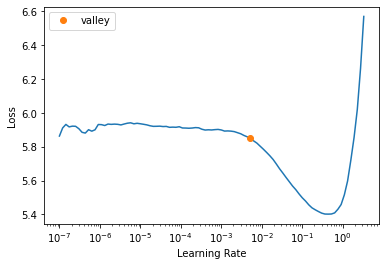

In [14]:
learn_lr = learn.lr_find().valley

In [15]:
learn.fit_one_cycle(1, learn_lr)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.482480,4.238575,0.244693,69.309052,00:20


In [16]:
learn.save_encoder('encoder_v0')

In [17]:
learn.unfreeze()
learn.fit_one_cycle(
    100, 
    learn_lr, 
    cbs=[
        EarlyStoppingCallback(
            monitor='accuracy', 
            min_delta=0, 
            patience=2
        ), 
        ReduceLROnPlateau(
            monitor='valid_loss', 
            comp=None, 
            min_delta=0.05, 
            patience=2, 
            factor=2.0, 
            min_lr=0, 
            reset_on_fit=True
        )
    ]
)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.023570,3.982139,0.269224,53.631622,00:22
1,3.902814,3.904398,0.278328,49.620186,00:23
2,3.789955,3.845906,0.284218,46.801067,00:22
3,3.689545,3.803205,0.287499,44.844662,00:23
4,3.583824,3.777351,0.289189,43.700142,00:22
5,3.460791,3.772207,0.289305,43.475910,00:22
6,3.321266,3.788089,0.288513,44.171909,00:22
7,3.169397,3.835902,0.285504,46.335190,00:22


Epoch 6: reducing lr to 0.0005605315073490473
No improvement since epoch 5: early stopping


In [18]:
learn.save_encoder('encoder_v1')

In [19]:
learn.predict('ride is', n_words = 5)

'ride is great . i was always'

In [80]:
train_df1 = train_df.copy()
test_df1 = test_df.copy()

#train_df1.revcontent = train_df1.revcontent + '. ' + train_df1.phraselist
#test_df1.revcontent = test_df1.revcontent + '. ' + test_df1.phraselist

#train_df1.revcontent = train_df1.phraselist
#test_df1.revcontent = test_df1.phraselist

train_df1.revcontent = train_df1.phraselist + '. ' + train_df1.revcontent
test_df1.revcontent = test_df1.phraselist + '. ' + test_df1.revcontent

train_df1 = train_df1.drop(['phraselist'], axis = 1)
test_df1 = test_df1.drop(['phraselist'], axis = 1)

In [81]:
label_cols = list(train_df1.columns[2:])

def get_labels(row):
    #print(row)
    indcs = np.where(row != 0)[0]
    #print(indcs)
    if len(indcs) == 0:
        return "bland"
    return ";".join([label_cols[x] for x in indcs])
    
labels = train_df1[label_cols].apply(lambda row: get_labels(row), axis = 1)
train_df1["Labels"] = labels

labels = test_df1[label_cols].apply(lambda row: get_labels(row), axis = 1)
test_df1["Labels"] = labels

In [82]:
dls_clf = dls_blk.dataloaders(train_df1,
                              bs = 64,
                              seed = 20)

In [83]:
learn_clf = text_classifier_learner(dls_clf, 
                                    AWD_LSTM, 
                                    drop_mult=0.5,
                                    metrics = accuracy_multi).to_fp16()


learn_clf = learn_clf.load_encoder('encoder_v1')

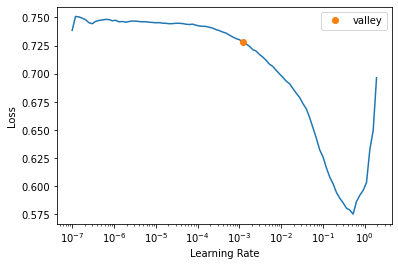

In [84]:
learn_clf_lr = learn_clf.lr_find().valley

In [85]:
learn_clf.fit_one_cycle(1, learn_clf_lr)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.733000,0.695805,0.478836,00:01


In [86]:
learn_clf.freeze_to(-2)
learn_clf.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.679106,0.651617,0.649471,00:01


In [87]:
learn_clf.freeze_to(-3)
learn_clf.fit_one_cycle(1, slice(5e-3/(2.6**4), learn_clf_lr))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.622594,0.652110,0.638889,00:01


In [88]:
learn_clf.unfreeze()
learn_clf.fit_one_cycle(
    100, 
    slice(1e-3/(2.6**4), learn_clf_lr),
    #1e-3,
    cbs=[
        EarlyStoppingCallback(
            monitor='accuracy_multi', 
            min_delta=0.0001, 
            patience=100
        )
#        ReduceLROnPlateau(
#            monitor='valid_loss', 
#            comp=None, 
#            min_delta=0.01, 
#            patience=2, 
#            factor=10.0, 
#            min_lr=0, 
#            reset_on_fit=True
#        )
    ]
)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.609386,0.650472,0.628307,00:01
1,0.607237,0.649240,0.625661,00:01
2,0.609529,0.648530,0.621693,00:01
3,0.608910,0.646555,0.625661,00:01
4,0.607351,0.646442,0.628307,00:01
5,0.607387,0.643786,0.634921,00:01
6,0.605813,0.644735,0.625661,00:01
7,0.602889,0.640350,0.634921,00:01
8,0.600885,0.639321,0.645503,00:01
9,0.597862,0.633501,0.654762,00:01


In [29]:
learn_clf.save('classifier.v5')

Path('models/classifier.v5.pth')

In [30]:
learn_clf = learn_clf.load('classifier.v5')

In [212]:
tok_inf_df = tokenize_df(test_df1, 'revcontent')
inf_dl = learn_clf.dls.test_dl(tok_inf_df[0])

# Predict probabilities for all the classes 
all_predictions = learn_clf.get_preds(dl = inf_dl, reorder = False)
probs = all_predictions[0].numpy()

In [213]:
class_list = list(test_df1.columns[2:-1])

In [214]:
indices = inf_dl.get_idxs()
predictions = pd.DataFrame(all_predictions[0].numpy(), columns = learn_clf.dls.vocab[1])
predictions['index'] = indices
predictions = pd.merge(predictions, test_df[['index', 'revcontent']], on='index')[test_df1.columns[1:-1]]
predictions = predictions.sort_values(by = ['index'])
predictions = predictions.reset_index(drop = True)
predictions = predictions.drop(['index'], axis = 1)

In [215]:
predictions

,revcontent,service,pricing,ride,maintenance,app,general,customercare,bike,payments
0,the best bicycle service in bangalore,0.661048,0.309337,0.057388,0.089455,0.490213,0.047780,0.080069,0.029930,0.089933
1,worst experience,0.039862,0.054702,0.119511,0.020765,0.210604,0.030157,0.053601,0.040541,0.015845
2,no option to search bike station,0.319865,0.038250,0.055926,0.085099,0.035411,0.026355,0.032713,0.369543,0.092688
3,very helpful particularly during lockdown and strike period this service look like a saviour,0.998345,0.028490,0.014957,0.010328,0.027638,0.062904,0.021698,0.012007,0.025420
4,great experience it easy to drive pollution free i just love to drive,0.211906,0.062217,0.076270,0.034619,0.034165,0.435241,0.017510,0.069668,0.032713
...,...,...,...,...,...,...,...,...,...,...
1019,"yulu maintained well at the launch and continuing the same. When you have good concept, you should improve it by providing good service.",0.086016,0.096877,0.019382,0.635336,0.098252,0.113383,0.027743,0.143068,0.026861
1020,Service is bad but maintenance is okay,0.959913,0.020332,0.053305,0.999503,0.037257,0.028061,0.046206,0.094510,0.049773
1021,hygenic maintenance at yulu zones,0.127979,0.028816,0.056133,0.188623,0.023689,0.024610,0.107063,0.127544,0.025275
1022,maintenance is upto the mark,0.020964,0.015248,0.038756,0.999997,0.015248,0.013956,0.014448,0.032283,0.041852


In [216]:
assessment_list = []
for col in train_df.columns[2:-1]:
    assessment_list.extend(list(predictions[col]))
    
truth_list = []
for col in train_df.columns[2:-1]:
    truth_list.extend(list(test_df[col]))

In [217]:
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [218]:
X = np.array(assessment_list).reshape(-1, 1)

y = np.array(truth_list).reshape(-1, 1)

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [220]:
clf = DecisionTreeClassifier(
    max_leaf_nodes=10000, 
    #random_state=0, 
    max_depth=50, 
    min_samples_leaf=10, 
    #min_impurity_decrease=0.001
)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=50, max_leaf_nodes=10000, min_samples_leaf=10)

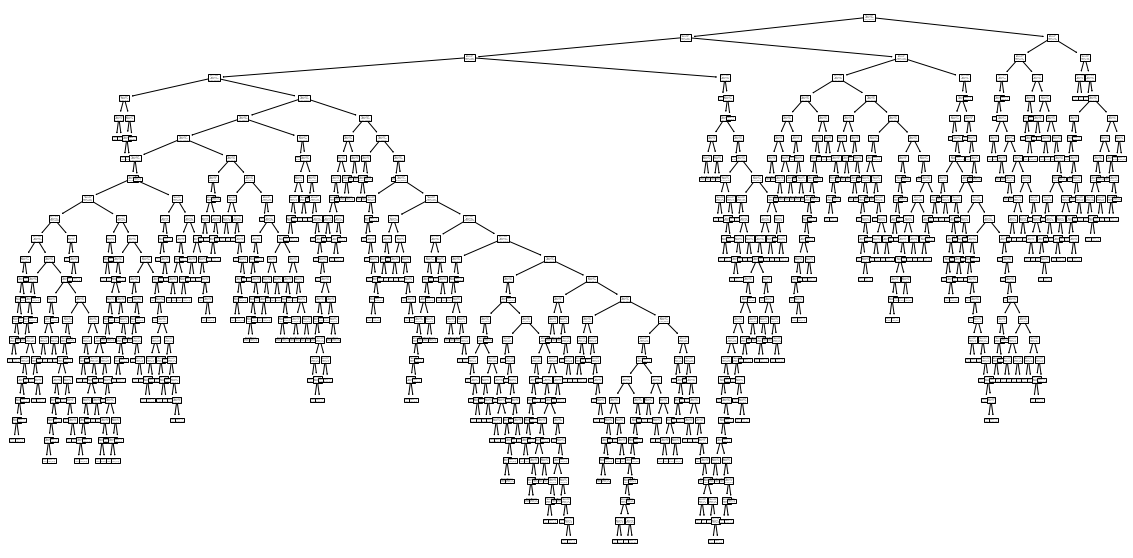

In [209]:
plt.figure(figsize=(20,10))
tree.plot_tree(clf)
plt.savefig('ruleset_posneg.pdf', dpi=320, format='pdf')
plt.show()

In [221]:
for col in predictions.columns[1:]:
    predictions[col] = predictions[col].swifter.apply(lambda x: np.round(100.*clf.predict_proba(np.array([x]).reshape(-1, 1))[0][1], 1))

Pandas Apply:   0%|          | 0/1024 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1024 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1024 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1024 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1024 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1024 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1024 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1024 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1024 [00:00<?, ?it/s]

In [224]:
predictions.to_excel('output.xlsx')

In [225]:
predictions

,revcontent,service,pricing,ride,maintenance,app,general,customercare,bike,payments
0,the best bicycle service in bangalore,63.6,5.6,0.0,7.1,20.0,0.0,0.0,0.0,36.4
1,worst experience,4.0,5.3,54.5,0.0,35.3,7.1,25.0,0.0,0.0
2,no option to search bike station,47.4,0.0,0.0,0.0,25.0,13.0,0.0,10.0,0.0
3,very helpful particularly during lockdown and strike period this service look like a saviour,100.0,13.3,0.0,0.0,5.3,36.4,0.0,0.0,6.7
4,great experience it easy to drive pollution free i just love to drive,0.0,0.0,0.0,8.3,11.8,70.0,0.0,12.5,0.0
...,...,...,...,...,...,...,...,...,...,...
1019,"yulu maintained well at the launch and continuing the same. When you have good concept, you should improve it by providing good service.",15.4,0.0,21.4,83.3,16.7,40.0,5.3,0.0,0.0
1020,Service is bad but maintenance is okay,100.0,6.7,15.4,100.0,14.3,6.2,9.1,25.0,0.0
1021,hygenic maintenance at yulu zones,30.0,20.0,0.0,50.0,11.8,0.0,0.0,30.0,9.1
1022,maintenance is upto the mark,5.0,0.0,4.8,100.0,0.0,0.0,0.0,7.7,0.0
